# Autograd: automatic differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

In [4]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 592.3MB 1.1MB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
     |████████████████████████████████| 748.8MB 23kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [5]:
import torch

Create a tensor:

In [6]:
# Create a 2x2 tensor with gradient-accumulation capabilities
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


Do an operation on the tensor:

In [7]:
# Deduct 2 from all elements
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [8]:
print(y.grad_fn)

In [9]:
# What's happening here?
print(x.grad_fn)

None


In [10]:
# Let's dig further...
y.grad_fn

In [11]:
y.grad_fn.next_functions[0][0]

In [12]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [13]:
# Do more operations on y
z = y * y * 3
a = z.mean()  # average

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [15]:
# Let's visualise the computational graph! (thks @szagoruyko)
!pip3 install torchviz

     |████████████████████████████████| 51kB 3.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=e4b1ffd0e99d952494c6a870416a5e9c8b9a5836c737b0391dbbc2999b80e9b5
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [17]:
from torchviz import make_dot

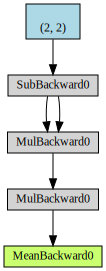

In [23]:
make_dot(a)

## Gradients

Let's backprop now `out.backward()` is equivalent to doing `out.backward(torch.tensor([1.0]))`

In [25]:
# Backprop
a.backward()

RuntimeError: ignored

Print gradients $\frac{\text{d}a}{\text{d}x}$.




In [26]:
# Compute it by hand BEFORE executing this
print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


You can do many crazy things with autograd!
> With Great *Flexibility* Comes Great Responsibility

In [27]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=True)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([1037.2921, 1040.0750, 1321.5338], grad_fn=<MulBackward0>)


In [28]:
# If we don't run backward on a scalar we need to specify the grad_output
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [29]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

9


## Inference

In [30]:
# This variable decides the tensor's range below
n = 3

In [31]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [32]:
# Only w that allows gradient accumulation
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

None
tensor([1., 2., 3.])


In [33]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## More stuff

Documentation of the automatic differentiation package is at
http://pytorch.org/docs/autograd.